# Ensemble Classifiers: Expanded Featureset
---

### Pre-Training Setup

In [52]:
import sys
sys.path.append('../') # Make parent folder visible
import numpy as np

from itertools import cycle
from scipy import interp

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer, fbeta_score, confusion_matrix, roc_curve, auc

from sklearn import svm, linear_model, neighbors, ensemble, naive_bayes, \
    neural_network, tree, gaussian_process, discriminant_analysis
    
import matplotlib.pyplot as plt
    
import scipy.stats as sp_stats

from preprocess import load_data

In [2]:
x, y, ids = load_data.load_expanded(one_hot=False, fill_mode='mean')

### Helper Functions/Classes

In [77]:
# Compute TN, FP, FN, TP
def compute_confusion(y_pred, y_test):
    confusion = confusion_matrix(y_test, y_pred) # calculate confusion matrix
    return confusion.flatten()

# Explain TN, FP, FN, TP
def explain_confusion(stats):
    fc_total = stats[0] + stats[1]
    kd_total = stats[2] + stats[3]
    fc_as_fc = (stats[0] / fc_total) * 100
    print("FC Classified as FC: " + str(stats[0]) + ", (" + str(fc_as_fc) + " %)")
    fc_as_kd = (stats[1] / fc_total) * 100
    print("FC Classified as KD: " + str(stats[1]) + ", (" + str(fc_as_kd) + " %)")
    kd_as_fc = (stats[2] / kd_total) * 100
    print("KD Classified as FC: " + str(stats[2]) + ", (" + str(kd_as_fc) + " %)")
    kd_as_kd = (stats[3] / kd_total) * 100
    print("KD Classified as KD: " + str(stats[3]) + ", (" + str(kd_as_kd) + " %)")

# Train and evaluate model using K-Fold CV, print out results, return ROC curves from each split
def test_model(model, x, y, threshold=0.5):
    stats_arr = []
    best_scores = []
    roc_curves = []
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=90007)
    for train_idx, test_idx in kf.split(x, y):
        x_train, x_test, y_train, y_test = x[train_idx], x[test_idx], y[train_idx], y[test_idx]
        best_score = model.train(x_train, y_train)
        best_scores.append(best_score)
        y_prob = model.predict_proba(x_test)
        y_pred = model.predict(x_test, threshold=threshold)
        roc_curves.append(roc_curve(y_test, y_prob)) # tuple (fpr, tpr, thresholds)
        stats_arr.append(compute_confusion(y_pred, y_test)) # confusion info info
    print('CV Confusion: ', [stats.tolist() for stats in stats_arr])
    print('Best CV scores: ', np.around(best_scores, decimals=4))
    print('Avg best scores: ', np.mean(best_scores))
    explain_confusion(np.mean(stats_arr, axis=0))
    return roc_curves

# Plot ROC Curves from K-Fold CV, show mean, variance across K-folds
    # Takes in a list of (fpr-array, tpr-array, threshold-array) tuples
def plot_cv_roc_curves(roc_curves):
    plt.figure(figsize=(10, 8))
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    i = 0
    for fpr, tpr, thresholds in roc_curves:
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.3f)' % (i, roc_auc))

        i += 1
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Luck', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.3f $\pm$ %0.3f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xticks(np.arange(0, 1, step=0.05))
    plt.yticks(np.arange(0, 1, step=0.05))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves Across K-Folds (Interpolated)')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()
    
# ScikitModel wrapper class
class ScikitModel:
    def __init__(self, skmodel, params, random_search=True, n_iter=10, scoring='roc_auc', beta=1.0, verbose=False):
        self.skmodel = skmodel
        self.cv_scorer = 'roc_auc' if scoring=='roc_auc' else make_scorer(fbeta_score, beta=beta)
        self.verbose = verbose
        if random_search == True: # Randomized grid search
            self.paramsearch = RandomizedSearchCV(self.skmodel, params, cv=5, 
                                        n_iter=n_iter,
                                        scoring=self.cv_scorer, 
                                        verbose=verbose)
        else: # Regular grid search
            self.paramsearch = GridSearchCV(self.skmodel, params, cv=5,
                                        scoring=self.cv_scorer, 
                                        verbose=verbose)
        
    # Run CV fit on x_train, y_train
    def train(self, x_train, y_train):
        self.paramsearch.fit(x_train, y_train)
        if self.verbose == True:
            print('Best params: ', self.paramsearch.best_params_)
            print('Best score: ', self.paramsearch.best_score_)
        return self.paramsearch.best_score_ # return ROC-AUC or f-beta
    
    # Predict on x_test, return probability that each patient is KD
    def predict_proba(self, x_test):
        y_prob = self.paramsearch.predict_proba(x_test)[:, 1]
        return y_prob
    
    # Predict on x_test, return binary y_pred
    def predict(self, x_test, threshold=0.5):
        y_prob = self.paramsearch.predict_proba(x_test)[:, 1] # probability of KD
        y_pred = np.array(y_prob >= threshold).astype(np.int32) # thresholding
        return y_pred

    # Train on x_train and y_train, and predict on x_test
    def train_test(self, x_train, x_test, y_train, y_test, threshold=0.5):
        self.train(x_train, y_train)
        return self.predict(x_test, threshold=threshold)

### Test out Candidate Learners

In [ ]:
svm_rocs = test_model(ScikitModel(svm.SVC(probability=True), 
                       {
                           'C': np.logspace(-3, 3, 100),
                           'gamma': np.logspace(-3, 3, 100),
                           'kernel': ['linear', 'rbf', 'poly']
                       },
                       random_search=True,
                       n_iter=100,
                       scoring='roc_auc',
                       verbose=True),
                      x, y,
                      threshold=0.40)

In [79]:
lr_rocs = test_model(ScikitModel(linear_model.LogisticRegression(), 
                       params={
                           'C': np.logspace(-2, 2, 5)
                       },
                       random_search=False,
                       scoring='roc_auc',
                       verbose=True),
           x, y,
           threshold=0.4)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best params:  {'C': 0.01}
Best score:  0.983330902425
Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.2s finished


Best params:  {'C': 0.01}
Best score:  0.97744783695
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best params:  {'C': 1.0}
Best score:  0.982086419115
Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.2s finished


Best params:  {'C': 0.10000000000000001}
Best score:  0.978113205694
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best params:  {'C': 0.10000000000000001}
Best score:  0.981677474335
CV Confusion:  [[112, 13, 6, 158], [114, 11, 3, 161], [111, 13, 7, 157], [115, 9, 4, 160], [105, 19, 6, 158]]
Best CV scores:  [ 0.9833  0.9774  0.9821  0.9781  0.9817]
Avg best scores:  0.980531167703
FC Classified as FC: 111.4, (89.5498392283 %)
FC Classified as KD: 13.0, (10.4501607717 %)
KD Classified as FC: 5.2, (3.17073170732 %)
KD Classified as KD: 158.8, (96.8292682927 %)


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.2s finished


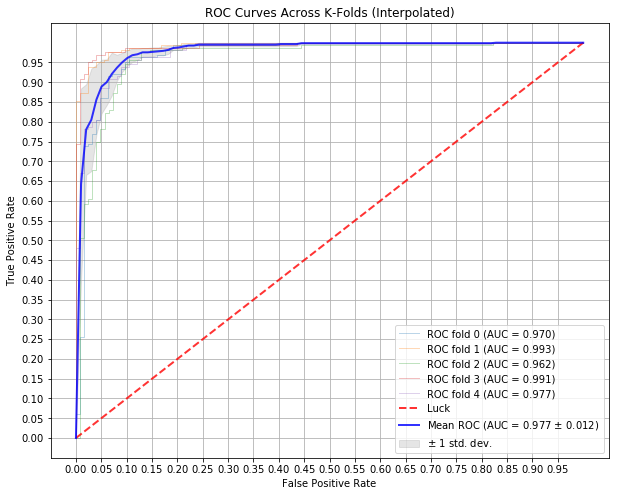

In [80]:
plot_cv_roc_curves(lr_rocs)

## SKLearn Ensemble Model

In [22]:
# Grid search params
clf1 = svm.SVC(probability=True)
clf2 = linear_model.LogisticRegression()

eclf = ensemble.VotingClassifier(
    estimators=[('svm', clf1), ('lr', clf2)],
    voting='soft')

params = {
    'svm__C': np.logspace(-3, 2, 100),
    'svm__gamma': np.logspace(-3, 2, 100),
    'svm__kernel': ['linear', 'rbf', 'poly'],
    'lr__C': np.logspace(-3, 2, 100)
}

# Test model! 5-fold CV with hyperparameter optimization
clf = ScikitModel(
    eclf,
    params,
    random_search=True, 
    n_iter=100, 
    verbose=True)

test_model(clf, x, y, threshold=0.4)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  2.0min finished


Best params:  {'svm__kernel': 'linear', 'svm__gamma': 0.01830738280295368, 'svm__C': 0.01291549665014884, 'lr__C': 0.019179102616724886}
Best score:  0.983728411141
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  2.6min finished


Best params:  {'svm__kernel': 'linear', 'svm__gamma': 22.051307399030456, 'svm__C': 62.802914418342468, 'lr__C': 0.012045035402587823}
Best score:  0.978078518279
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  1.8min finished


Best params:  {'svm__kernel': 'rbf', 'svm__gamma': 0.75646332755462908, 'svm__C': 0.010235310218990263, 'lr__C': 0.79248289835391772}
Best score:  0.983738927235
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  1.8min finished


Best params:  {'svm__kernel': 'linear', 'svm__gamma': 0.010235310218990263, 'svm__C': 0.029150530628251757, 'lr__C': 0.014508287784959394}
Best score:  0.978526589803
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best params:  {'svm__kernel': 'linear', 'svm__gamma': 0.0025353644939701114, 'svm__C': 0.0015922827933410922, 'lr__C': 43.287612810830616}
Best score:  0.982074962653
CV Confusion:  [[115, 10, 10, 154], [113, 12, 4, 160], [106, 18, 6, 158], [114, 10, 4, 160], [106, 18, 6, 158]]
Best CV scores:  [ 0.9837  0.9781  0.9837  0.9785  0.9821]
Avg best scores:  0.981229481822
FC Classified as FC: 110.8, (89.0675241158 %)
FC Classified as KD: 13.6, (10.9324758842 %)
KD Classified as FC: 6.0, (3.65853658537 %)
KD Classified as KD: 158.0, (96.3414634146 %)


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  2.1min finished
